# 0.0. IMPORTS

In [88]:
import pandas as pd
import inflection
import math
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from boruta                        import BorutaPy
from scipy                         import stats
from IPython.core.display          import HTML
from IPython.display               import Image

from sklearn.preprocessing         import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics               import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble              import RandomForestRegressor
from sklearn.linear_model          import LinearRegression, Lasso

import warnings

warnings.filterwarnings("ignore")

### 0.1. Helper Functions

In [2]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
    
def ml_error(model_name, y, yhat):

    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },
        index=[0])

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr =  k - (k-1)**2/(n-1)
    rcorr =  r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/ (min(kcorr-1,rcorr-1)))

def cross_validation(model_name, x_training , kfold , model , verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold + 1)):
        if verbose:
            print(f'\nKfold Number: {k}')
        # start and end date for validatio
        validation_start_date = x_training['date'].max()- datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].max()- datetime.timedelta(days = (k-1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation  = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # trainig and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis =1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date','sales'], axis =1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat_m = m.predict(xvalidation)

        #performance
        m_result_v= ml_error(model_name , np.expm1(yvalidation) , np.expm1(yhat_m))


        # store perfomance of each kfold iteration
        mae_list.append(m_result_v['MAE'])
        mape_list.append(m_result_v['MAPE'])
        rmse_list.append(m_result_v['RMSE'])

    return  pd.DataFrame({  'Model Name': model_name,
                            'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                            'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                            'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index = [0])

In [3]:
my_settings()

### 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv' , low_memory = False)
df_store_raw = pd.read_csv('data/store.csv' , low_memory = False)

# merge

df_raw = pd.merge(df_sales_raw , df_store_raw , how = 'left' , on = 'Store')

In [6]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS


### 1.1. Rename Columns

In [7]:
df1 = df_raw.copy()

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase , cols_old))

# rename

df1.columns = cols_new



In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2. Data Dimensions

In [11]:
print( ' Number of rows: {}'.format(df1.shape[0]))
print( ' Number of rows: {}'.format(df1.shape[1]))


 Number of rows: 1017209
 Number of rows: 18


### 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

In [14]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
902453,89,6,2013-04-13,3996,420,1,0,0,0,a,a,2380.00,7.00,2004.00,1,40.00,2014.00,"Jan,Apr,Jul,Oct"


In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
# competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x) 

# competition_open_since_month    
df1['competition_open_since_month']= df1.apply(lambda x :x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'] , axis = 1)

# competition_open_since_year     
df1['competition_open_since_year']= df1.apply(lambda x :x['date'].year  if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'] , axis = 1)

# promo2_since_week  
df1['promo2_since_week']= df1.apply(lambda x :x['date'].week  if math.isnan(x['promo2_since_week']) else x['promo2_since_week'] , axis = 1)

# promo2_since_year 
df1['promo2_since_year']= df1.apply(lambda x :x['date'].year  if math.isnan(x['promo2_since_year']) else x['promo2_since_year'] , axis = 1)

# promo_interval  
month_map = {1 : 'Jan' ,2 : 'Fev' ,3 : 'Mar' ,4 : 'Apr' ,5 : 'May' ,6 : 'Jun' ,7 : 'Jul' ,8 : 'Aug' ,9 : 'Set' ,10 : 'Out' ,11 : 'Nov' ,12 : 'Dez' }

df1['promo_interval'].fillna(0 , inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0 , axis = 1)


In [17]:
df1.sample(5).T

,326452,683134,527834,1003965,70365
store,374,425,110,136,121
day_of_week,5,7,6,6,5
date,2014-09-26 00:00:00,2013-10-27 00:00:00,2014-03-15 00:00:00,2013-01-12 00:00:00,2015-05-29 00:00:00
sales,6256,0,2601,3660,5103
customers,764,0,348,317,613
open,1,0,1,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,a,a


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Change Types

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

### 1.7. Descriptive Statistical 

In [20]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'] )

#### 1.7.1. Numerical Attributes

In [21]:
# Central tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns =['attributes','min','max','range','mean','median','std','skew','kustosis']

In [22]:
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

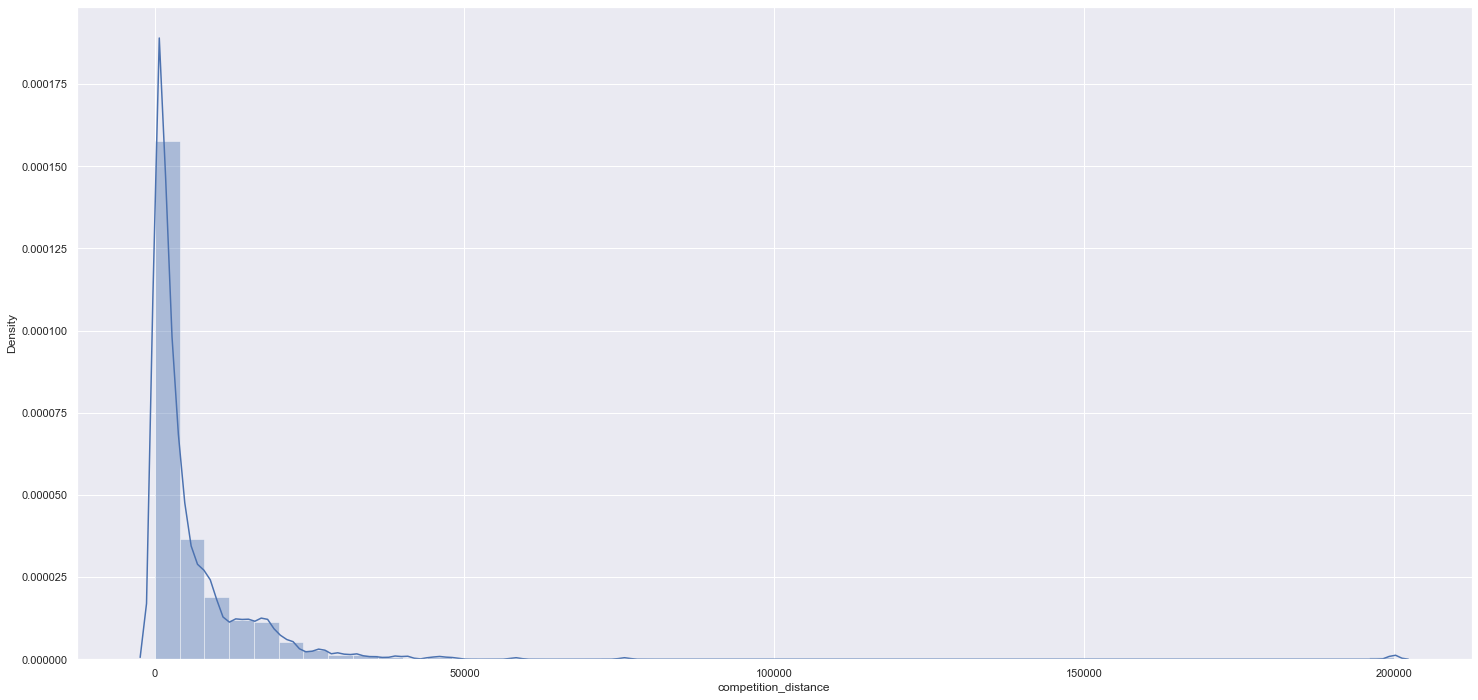

In [23]:
sns.distplot(df1['competition_distance'])


#### 1.7.2. Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

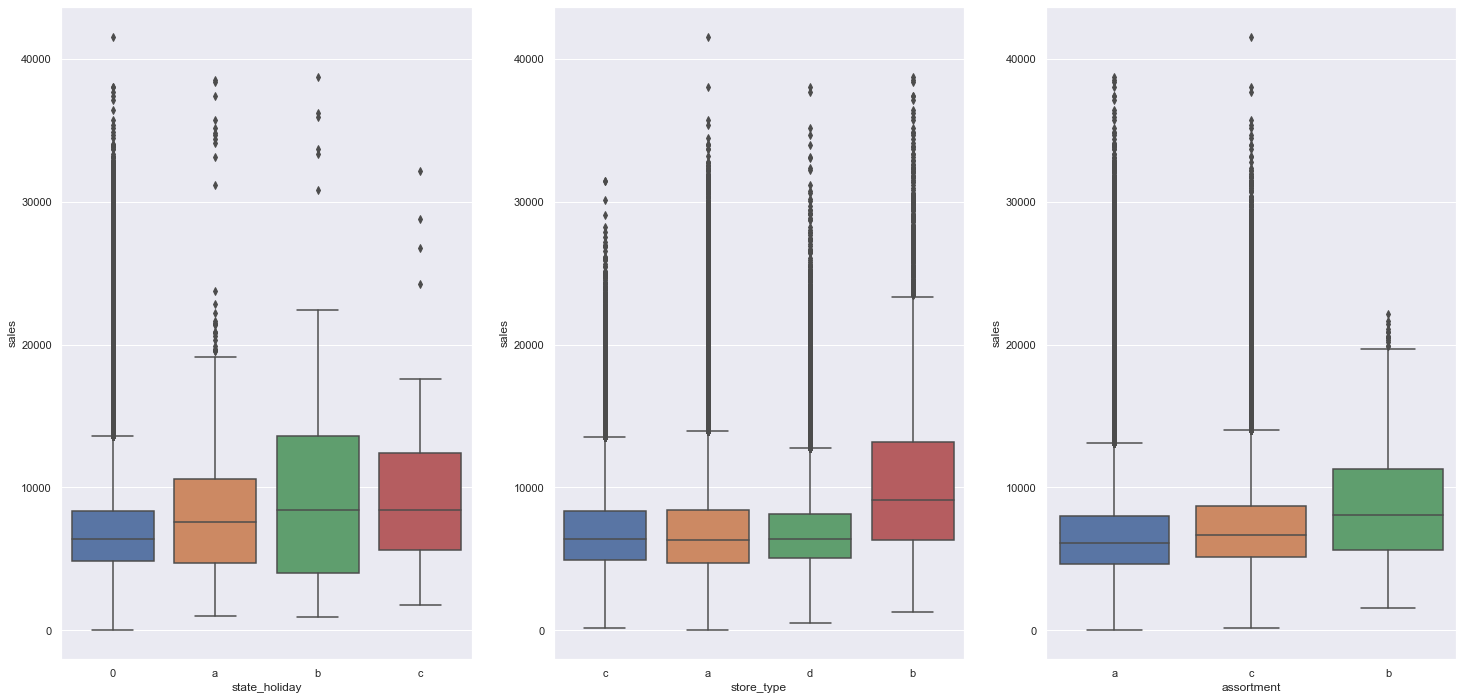

In [25]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x ='state_holiday' , y ='sales' , data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x ='store_type' , y ='sales' , data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x ='assortment' , y ='sales' , data = aux1)

# 2.0. FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1. Mapa mental de Hipoteses

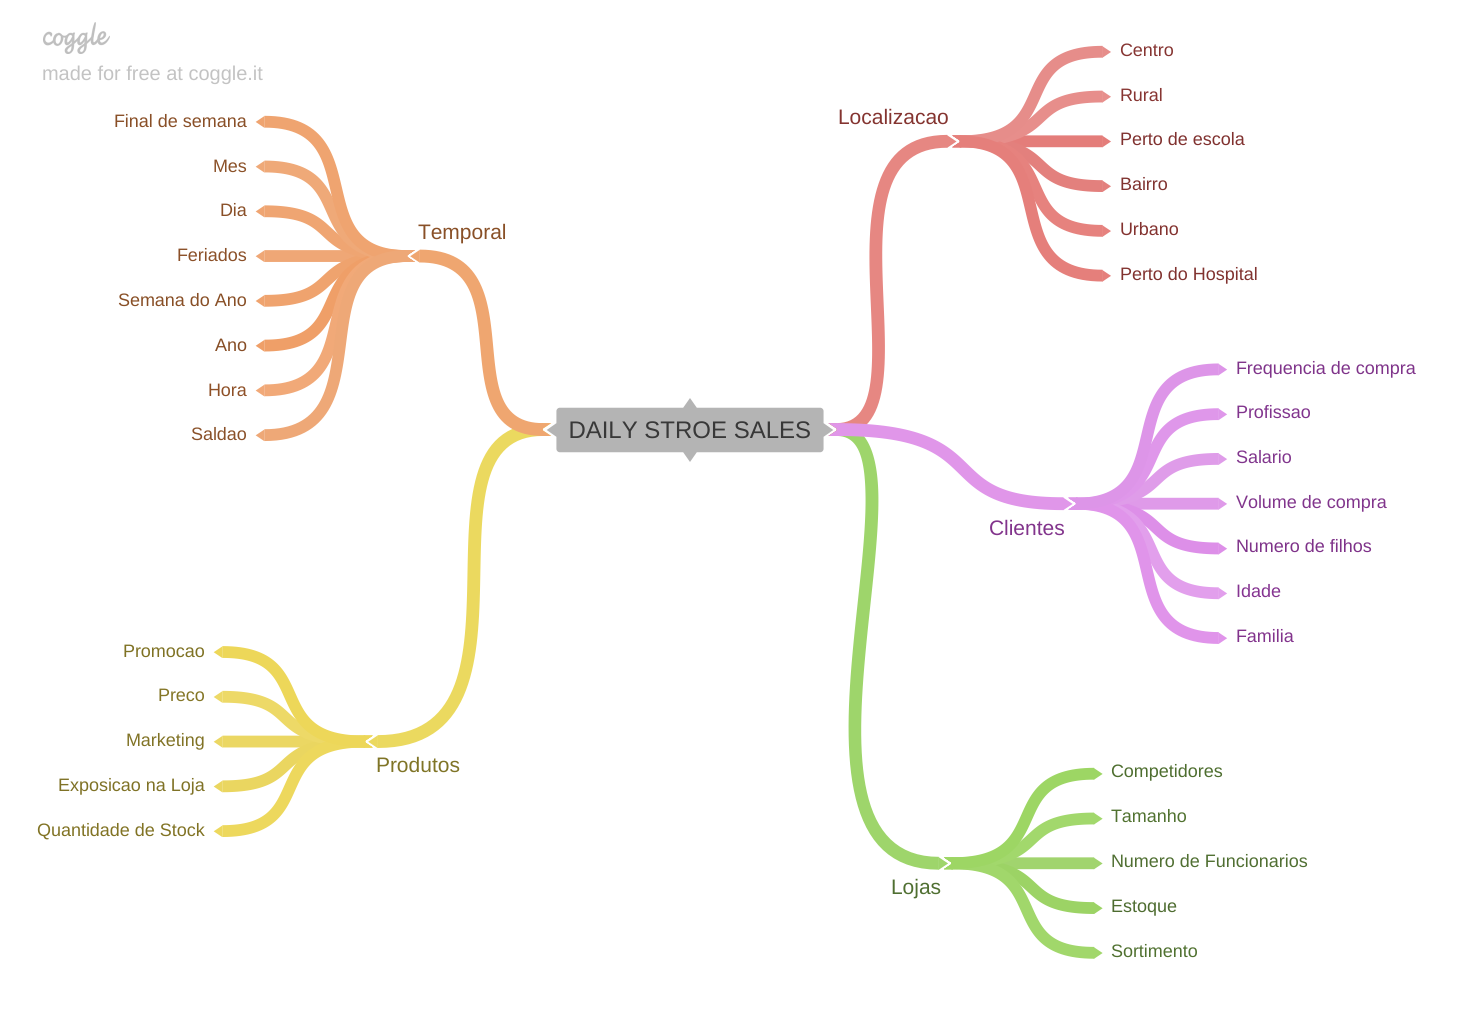

In [27]:
Image('img/MindMapHypothesys.png')

### 2.1.1. Hipotese Loja

**1.** Lojas com numero maior de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor estoque deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores proximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções agressivas(descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoções a deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipotese Temporal

**1.** Lojas abertas durante feriado de Natal deveriam vender menos.

**2.** Lojas deveriam vender mais ao longo do ano.

**3.** Lojas deveriam vender mais no segundo semetre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender mais aos finais de semana.

**6.** Lojas deveriam vender menos durante feriados escolares.




## 2.2. Lista final das Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores proximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoções deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante feriado de Natal deveriam vender menos.

**8.** Lojas deveriam vender mais ao longo do ano.

**9.** Lojas deveriam vender mais no segundo semetre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante feriados escolares.



## 2.3. Feature Engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x : datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day=1 ), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x : datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [30]:
df3 = df2.copy()

### 3.1. Filtragem das Linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Selecao das Colunas

In [32]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop , axis = 1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS (EDA)

In [34]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

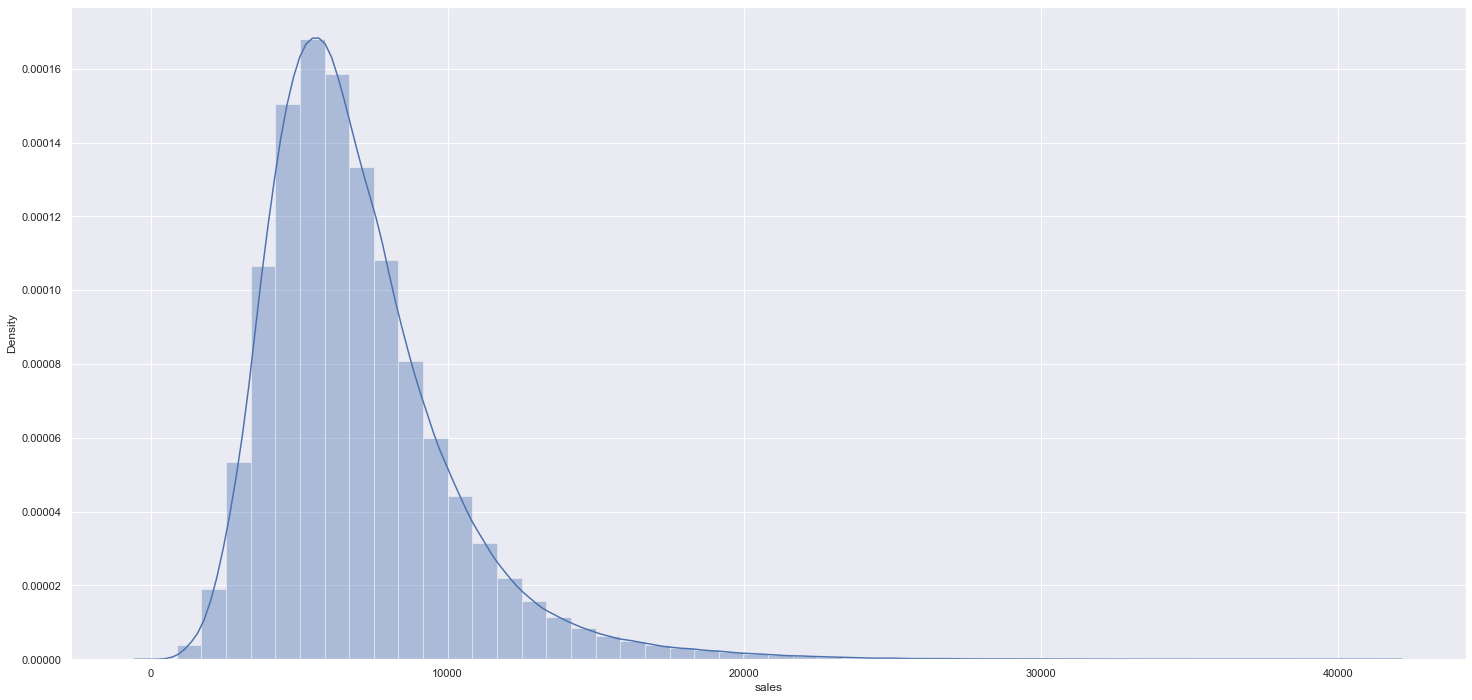

In [35]:
sns.distplot((df4['sales']))

### 4.1.2. Numerical Variable

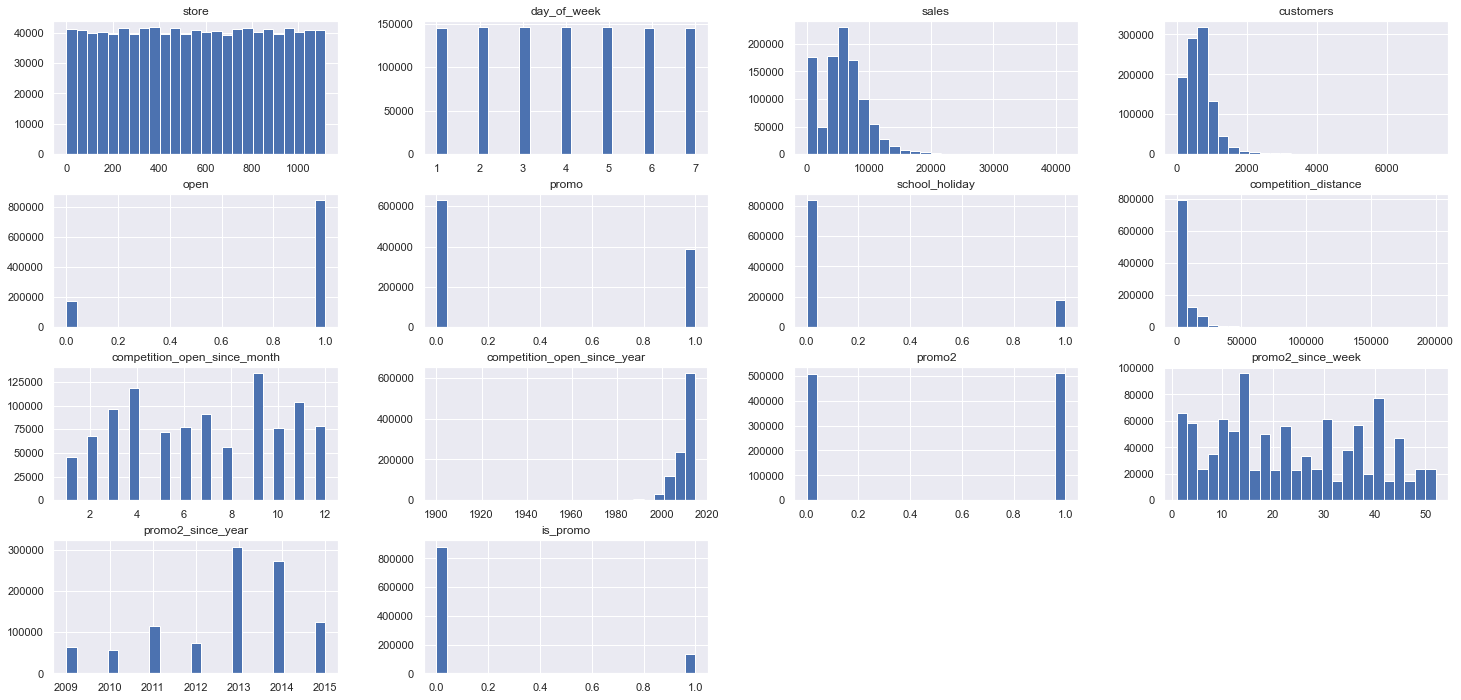

In [36]:
num_attributes.hist(bins=25)

### 4.1.3. Categorical Variable

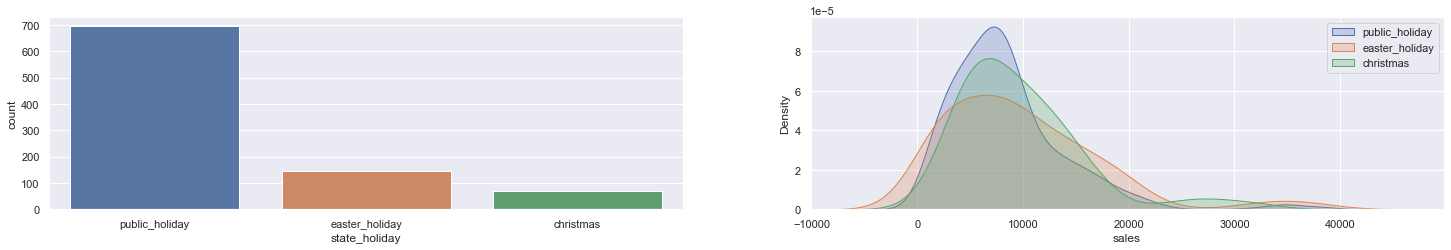

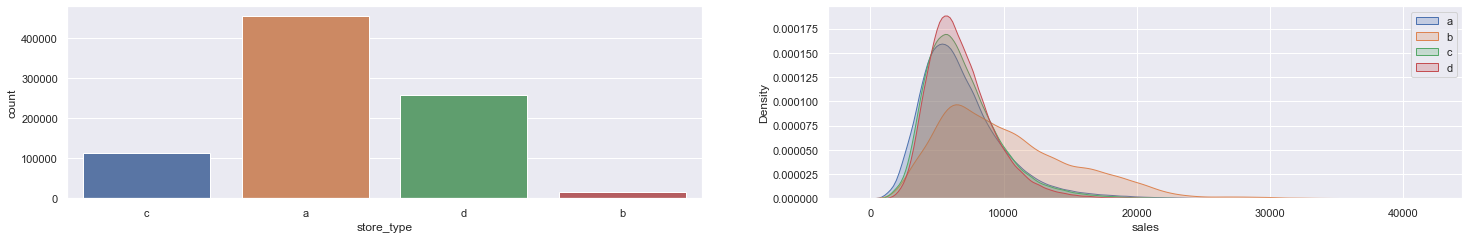

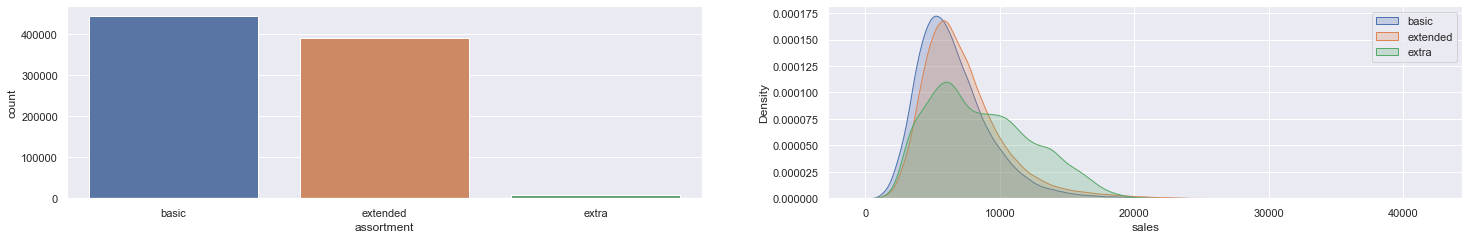

In [37]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
            label='christmas',
            shade=True)

plt.legend()
plt.show()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

plt.legend()
plt.show()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra',
            shade=True)

plt.legend()
plt.show()

## 4.2. Analise Bivariada

#### **H1.** Lojas com maior sortimento deveriam vender mais.
***False*** -  Lojas com MAIOR SORTIMENTO vendem MENOS.




In [38]:
df4['assortment'].value_counts(normalize=True)

basic      0.53
extended   0.46
extra      0.01
Name: assortment, dtype: float64

In [39]:
(df4.groupby('assortment').agg({'sales': 'sum'}) / df4['sales'].sum() *
 100).reset_index()

,assortment,sales
0,basic,50.16
1,extended,48.64
2,extra,1.21


<AxesSubplot:xlabel='year_week'>

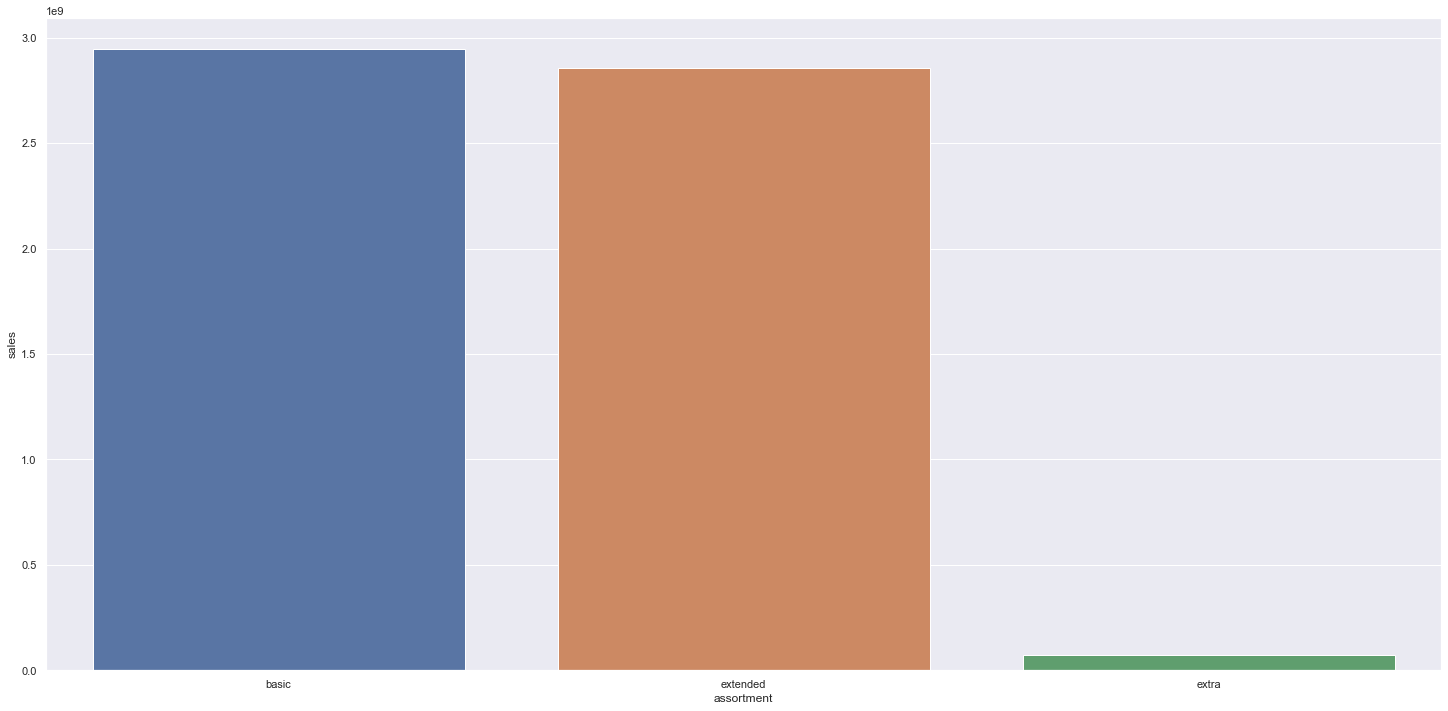

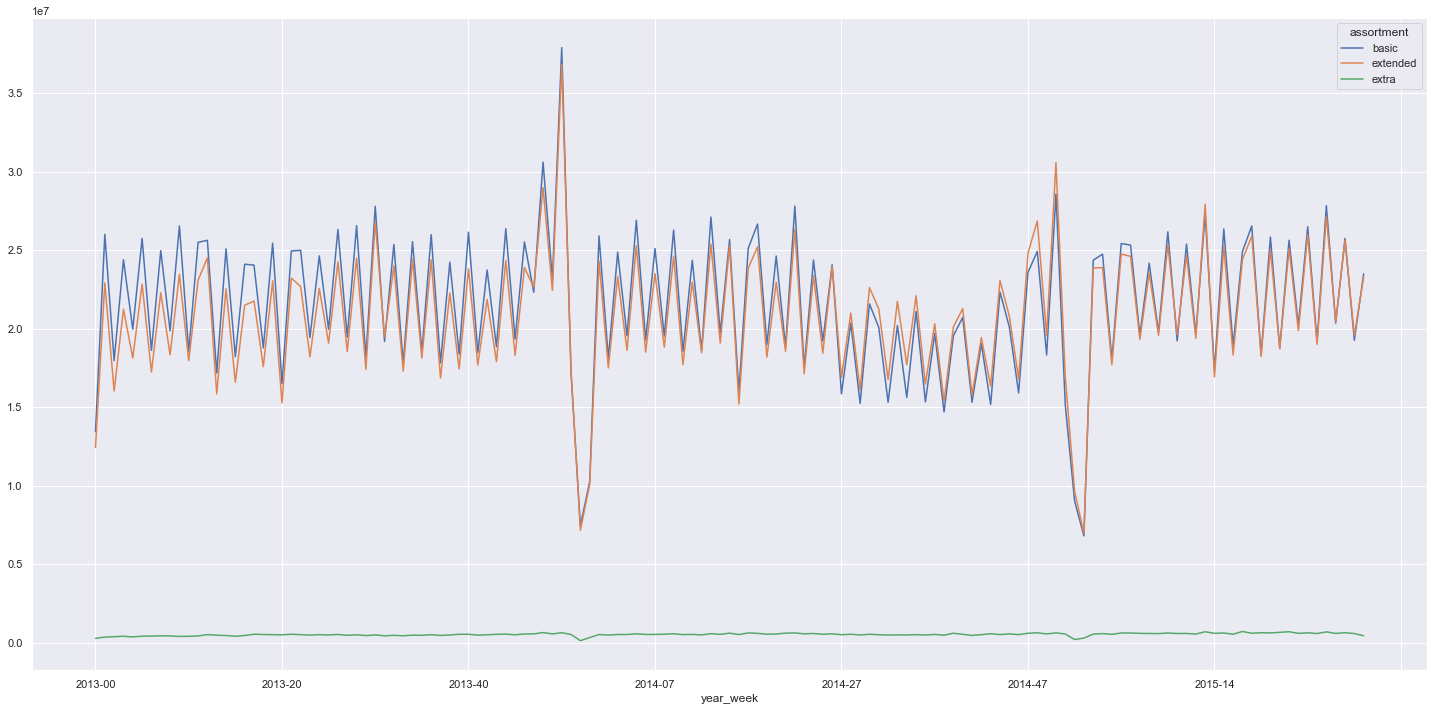

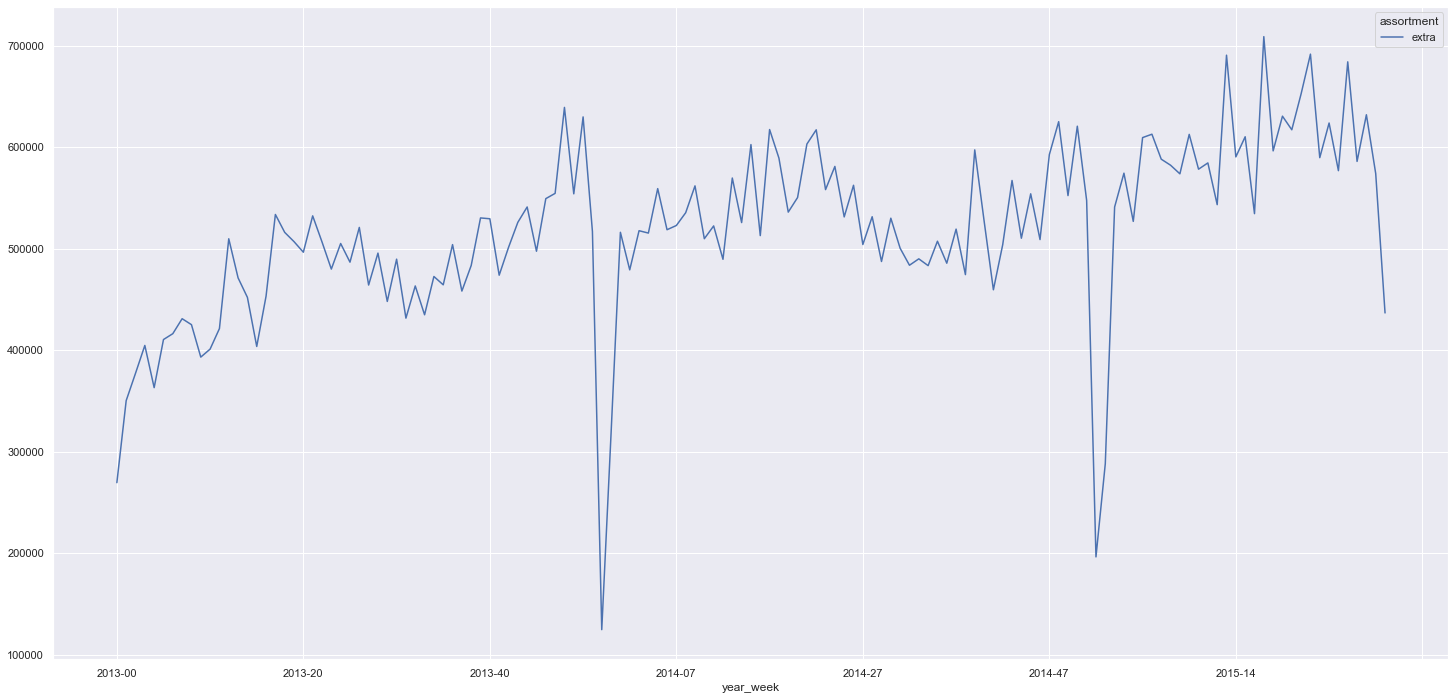

In [40]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment',
            'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2.** Lojas com competidores proximos deveriam vender menos.
***False*** -  Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.


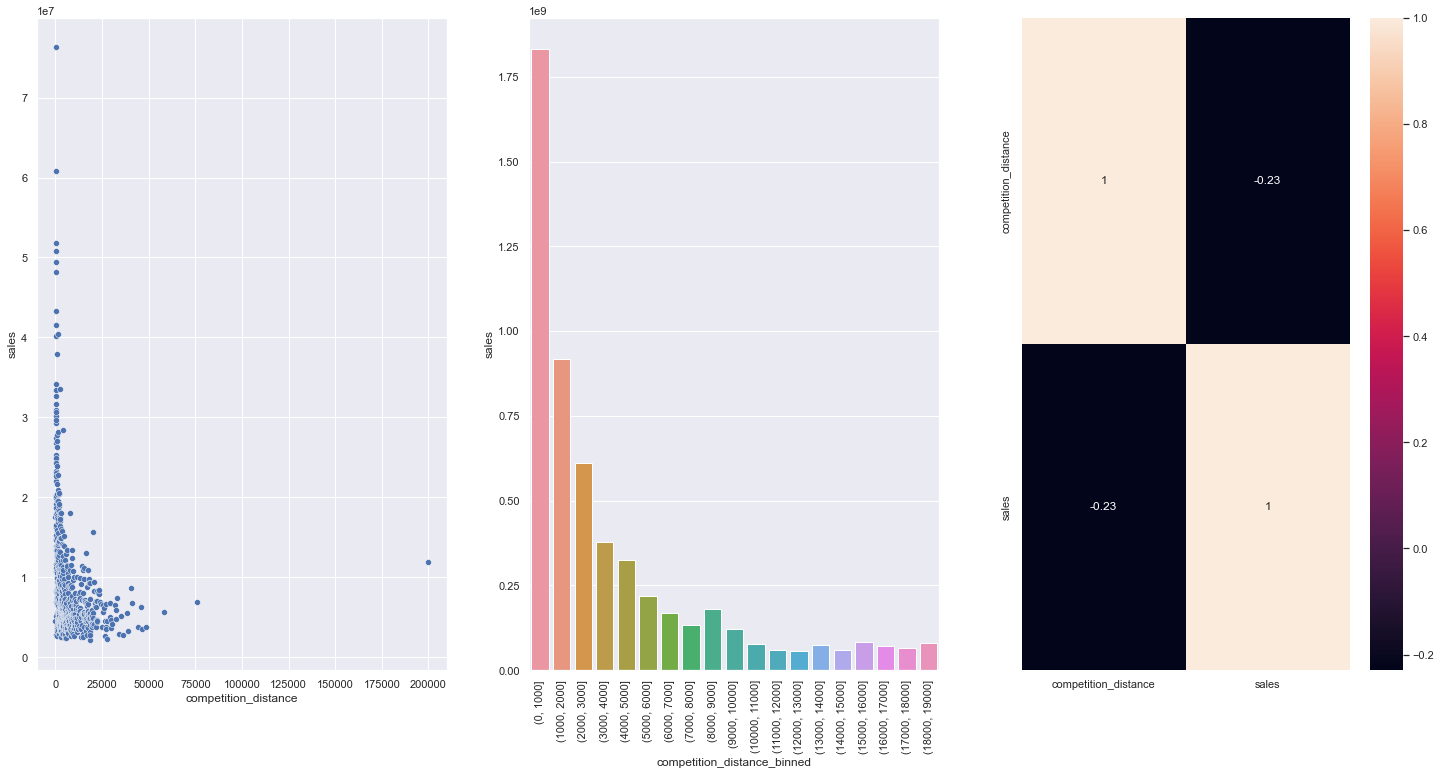

In [41]:
aux1 = df4[['competition_distance',
            'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
***False*** -  Lojas com COMPETIDORES PROXIMOS À MAIS TEMPO vendem MENOS.


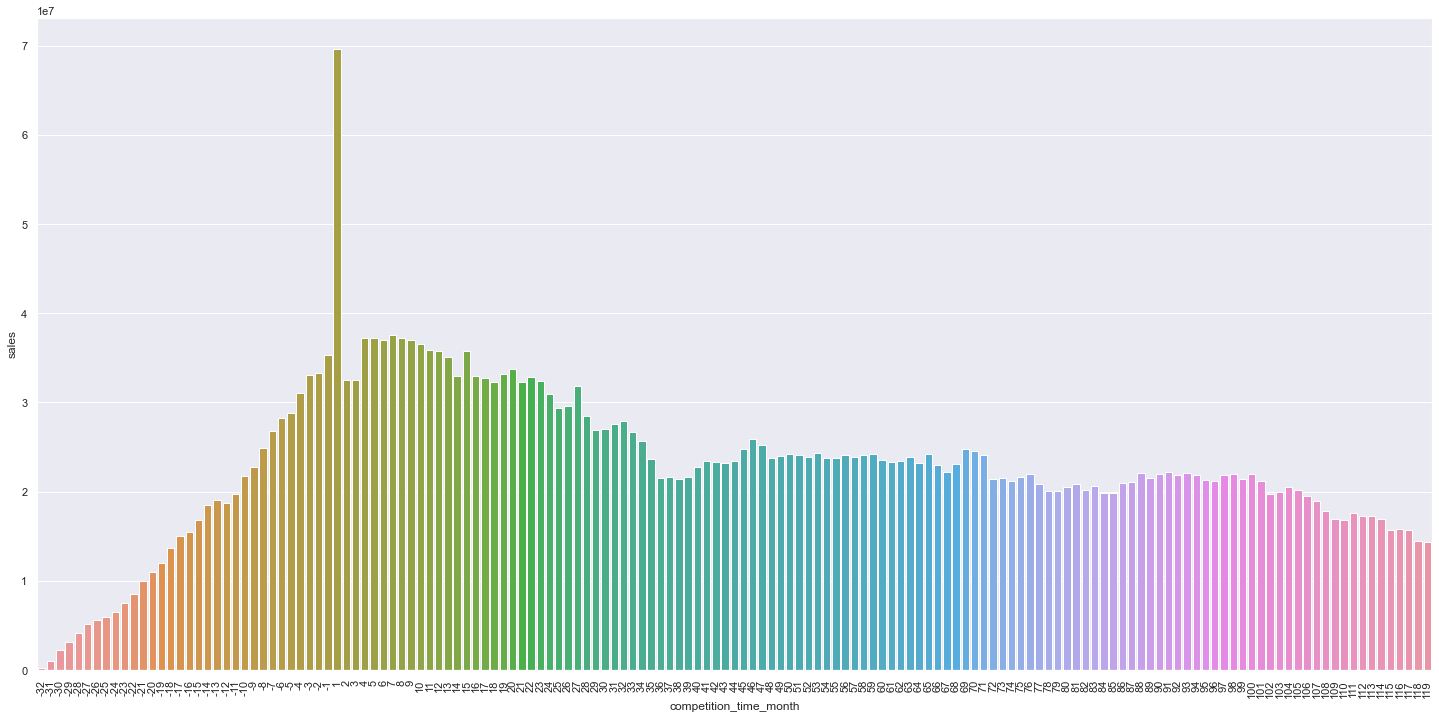

In [42]:
aux1 = df4[['competition_time_month',
            'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)
            & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

<AxesSubplot:>

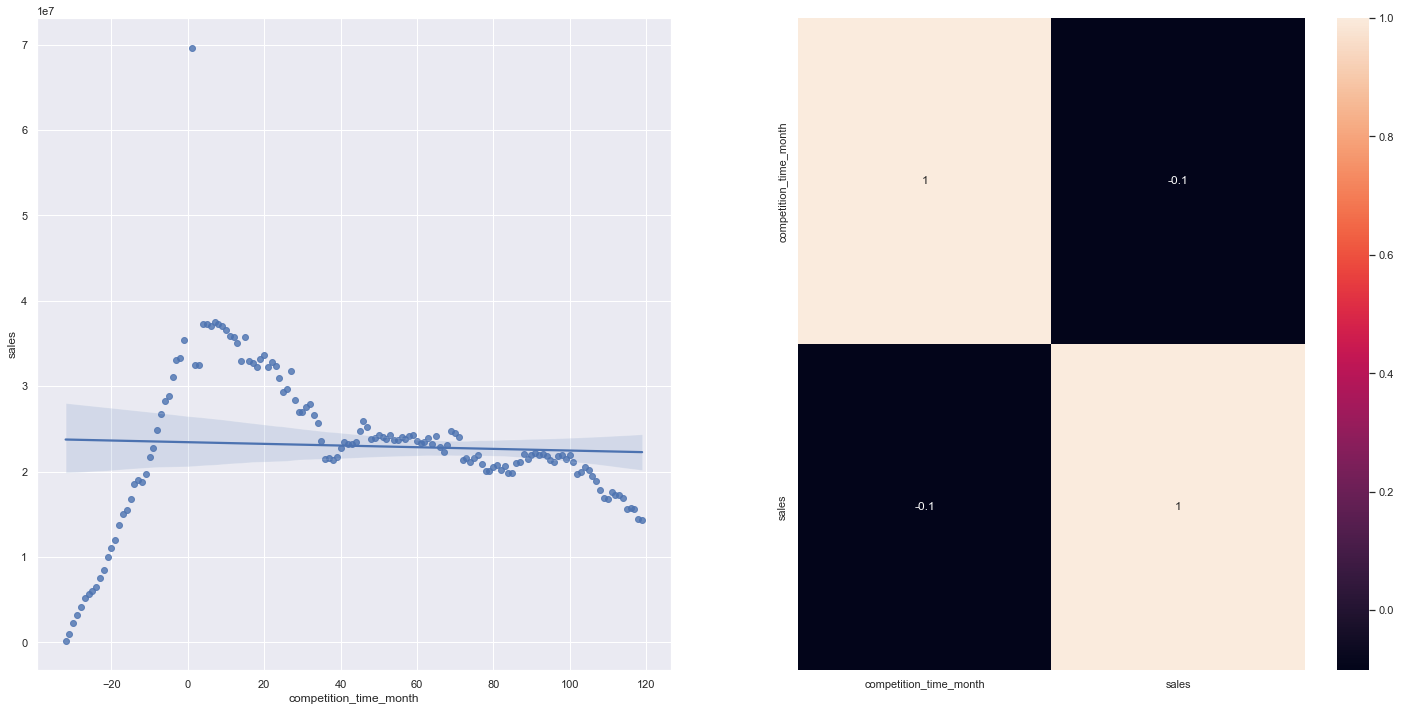

In [43]:
plt.subplot(1, 2, 1)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

***False*** -  Lojas com PROMOCOES ATIVAS À MAIS TEMPO vendem MENOS num certo periodo de promocao.




<AxesSubplot:>

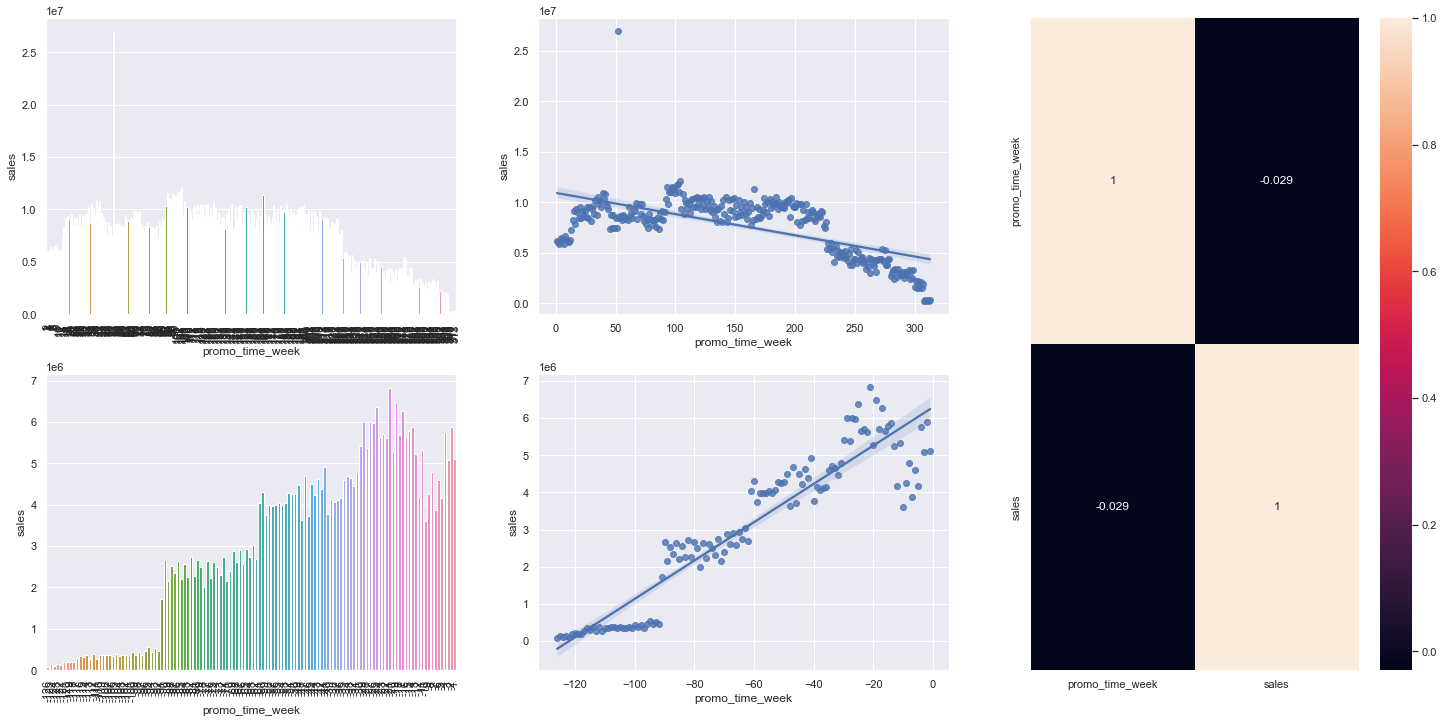

In [44]:
aux1 = df4[['promo_time_week',
            'sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # promocao extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promocao regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### <s>**H5.** Lojas com mais dias de promoções deveriam vender mais.</s>


#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

***False*** -  Lojas com MAIS PROMOCOES CONSECUTIVAS vendem MENOS.

In [45]:
df4[['promo', 'promo2', 'sales']].groupby(['promo',
                                           'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


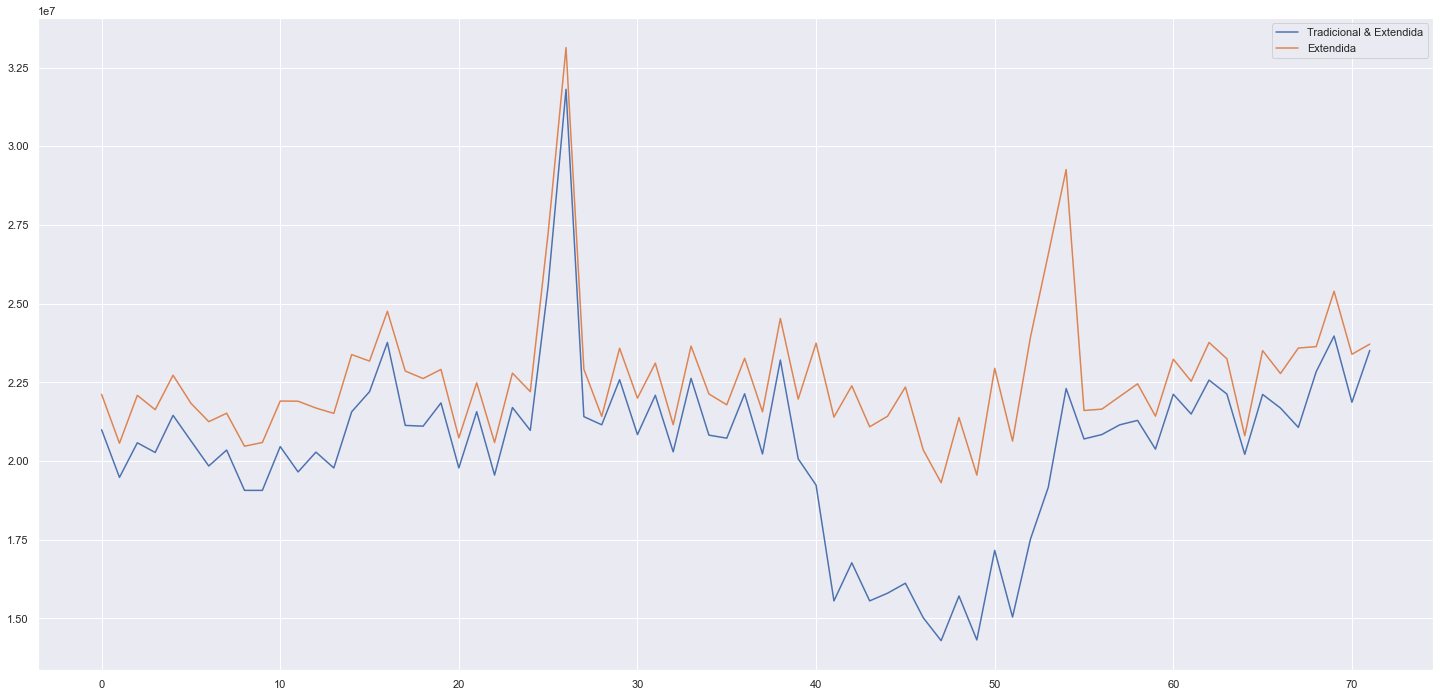

In [46]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

#### **H7.** Lojas abertas durante feriado de Natal deveriam vender menos.
***False*** -  Lojas NO NATAL vendem MENOS.

<AxesSubplot:xlabel='year', ylabel='sales'>

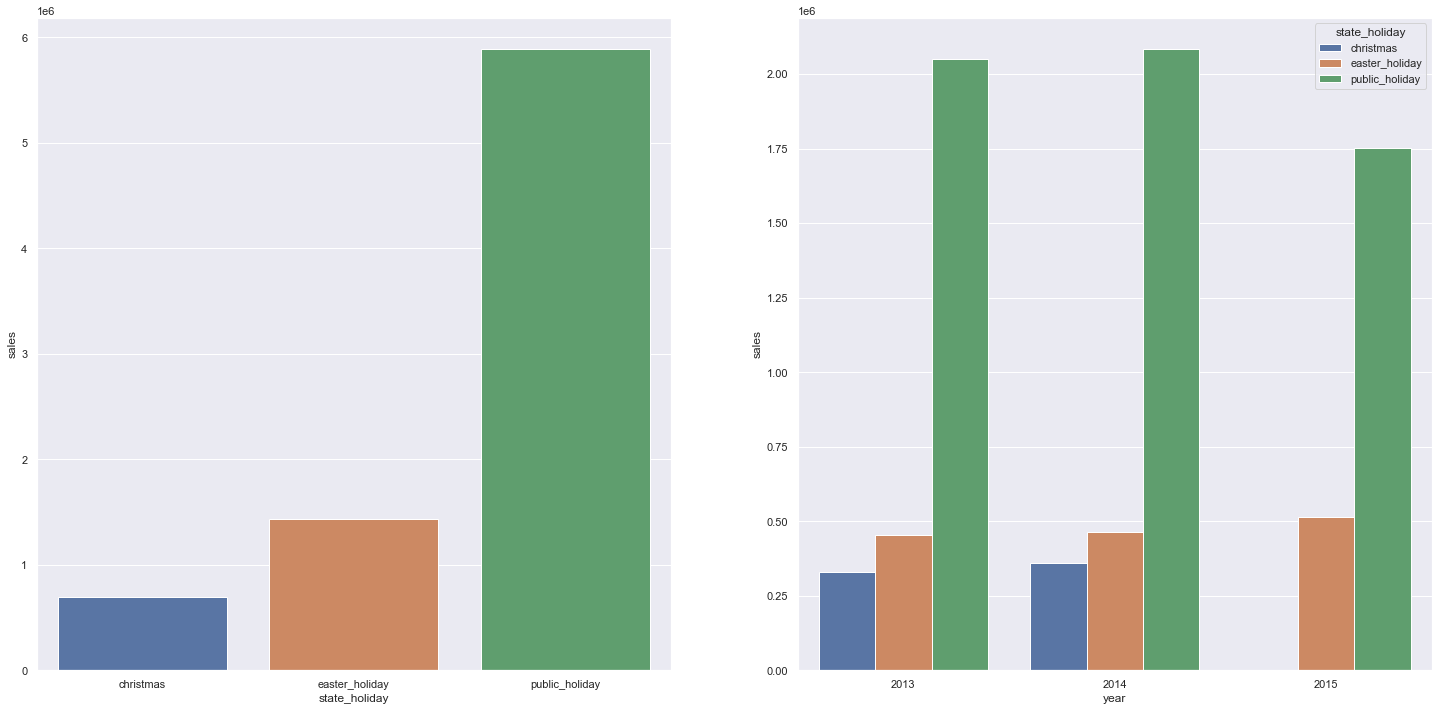

In [47]:
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday',
            'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday',
            'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

#### **H8.** Lojas deveriam vender mais ao longo do ano.
***False*** -  Lojas vendem MENOS ao longo dos anos.





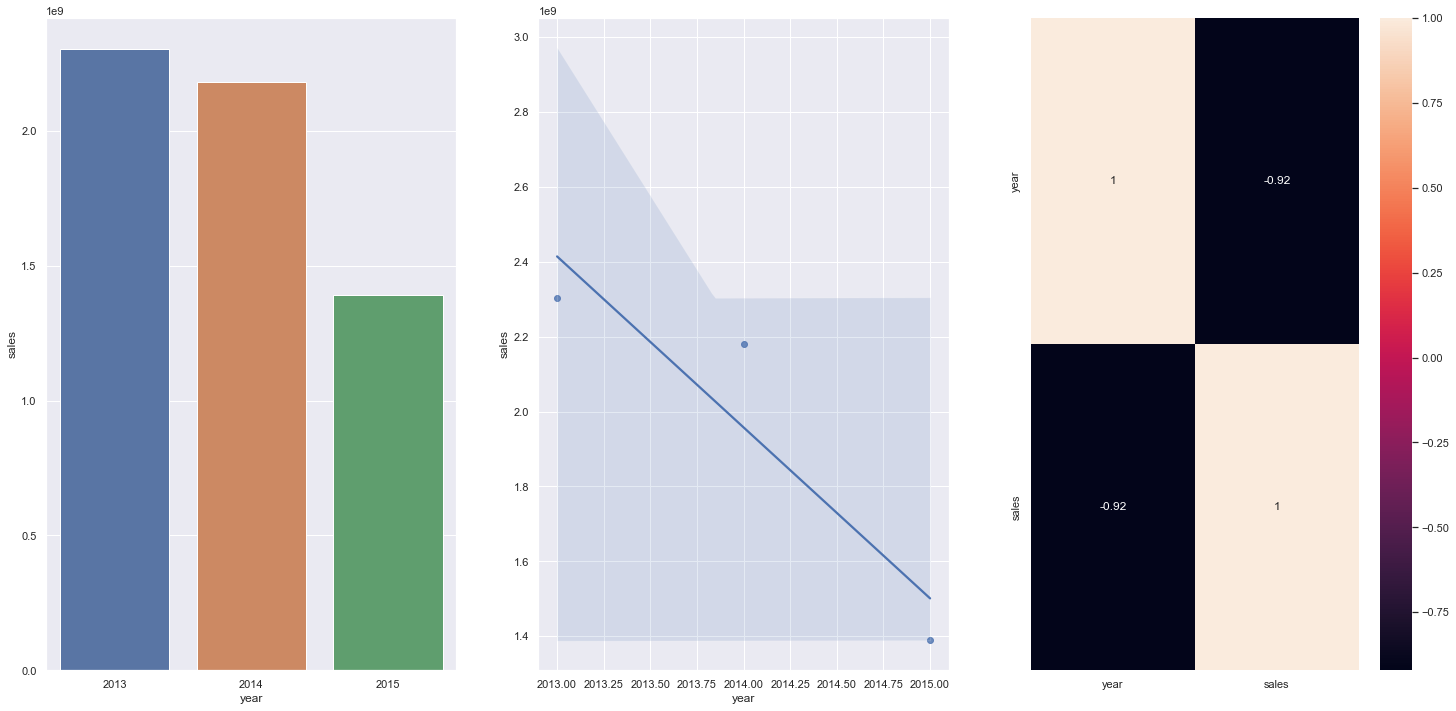

In [48]:
plt.subplot(1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H9.** Lojas deveriam vender mais no segundo semetre do ano.
***False*** -  Lojas vendem MENOS no SEGUNDO SEMSTRE DO ANO.


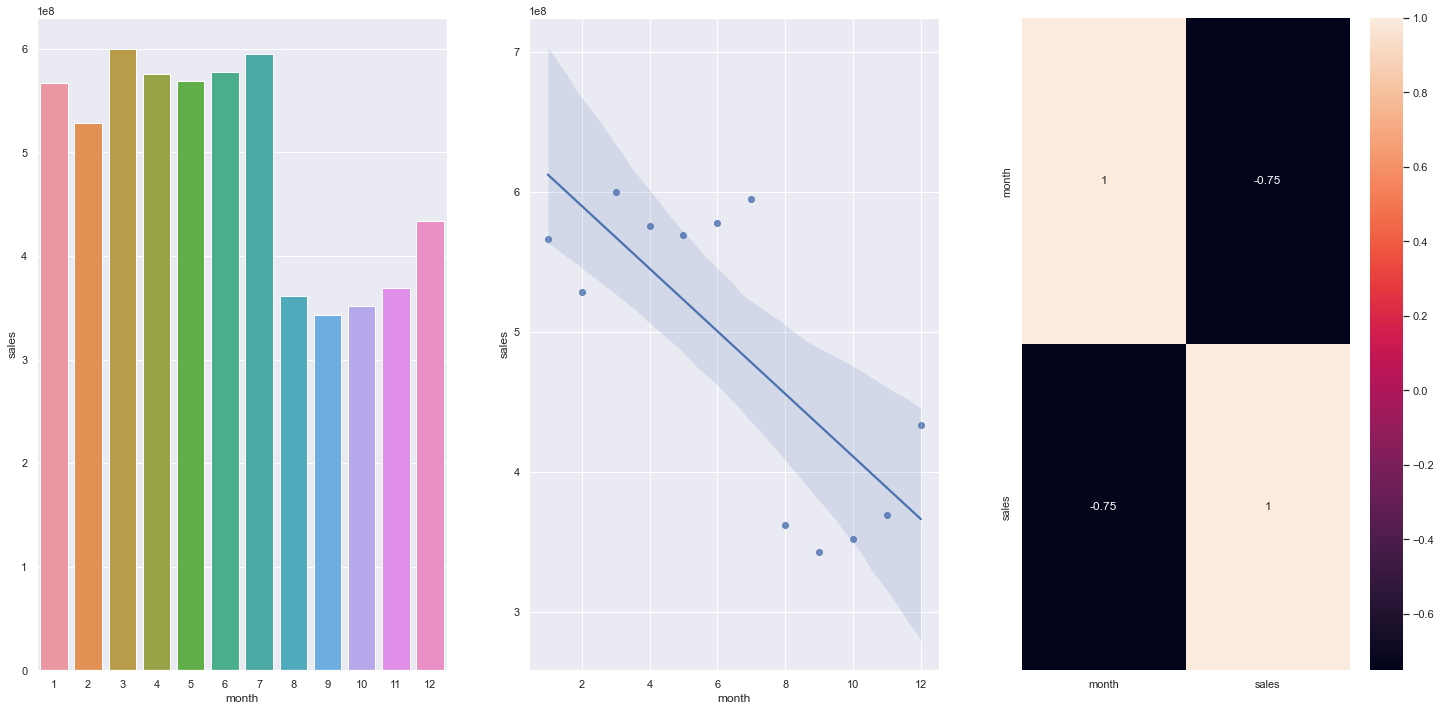

In [49]:
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***True*** -  Lojas vendem MAIS depois do dia 10 de casa mês.


<AxesSubplot:xlabel='before_after', ylabel='sales'>

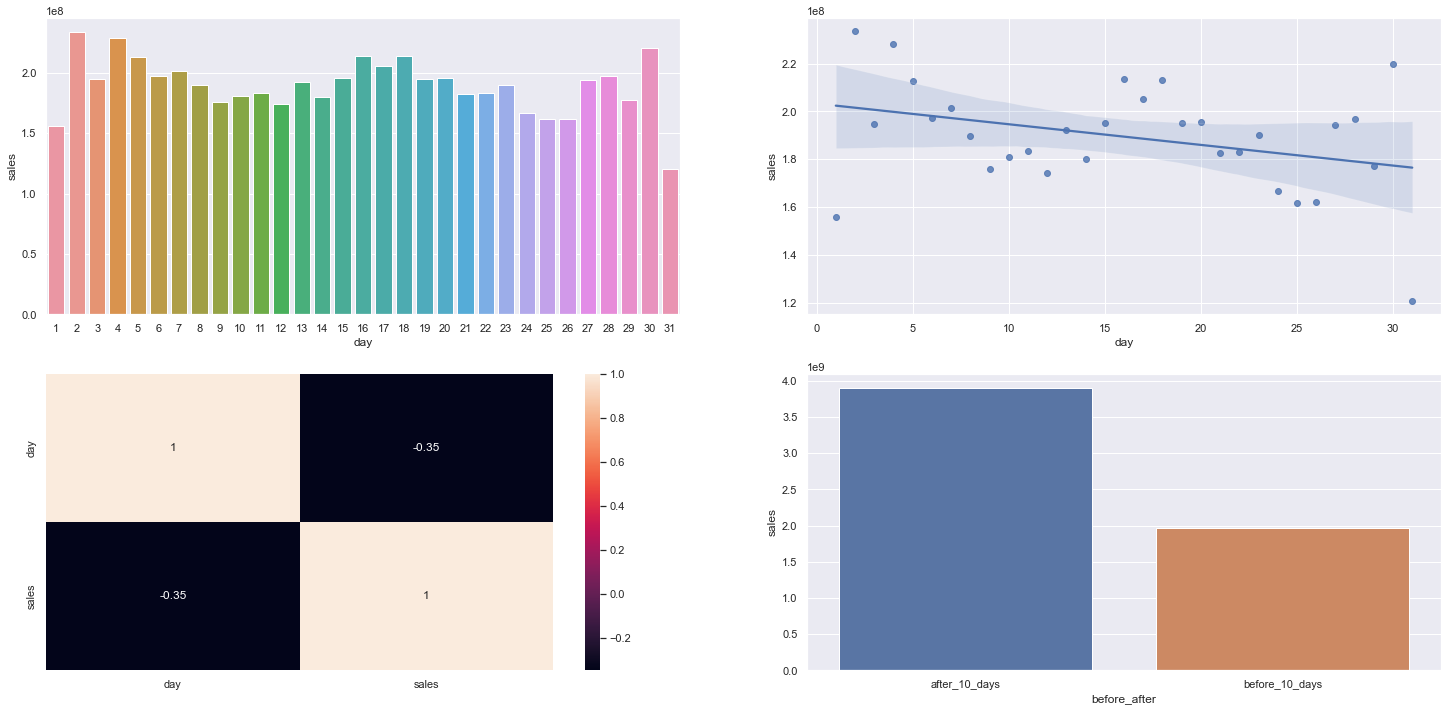

In [50]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days'
                                         if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after',
             'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

#### **H11.** Lojas deveriam vender menos aos finais de semana.
***True*** -  Lojas vendem MENOS nos FINAIS DE SEMANA.


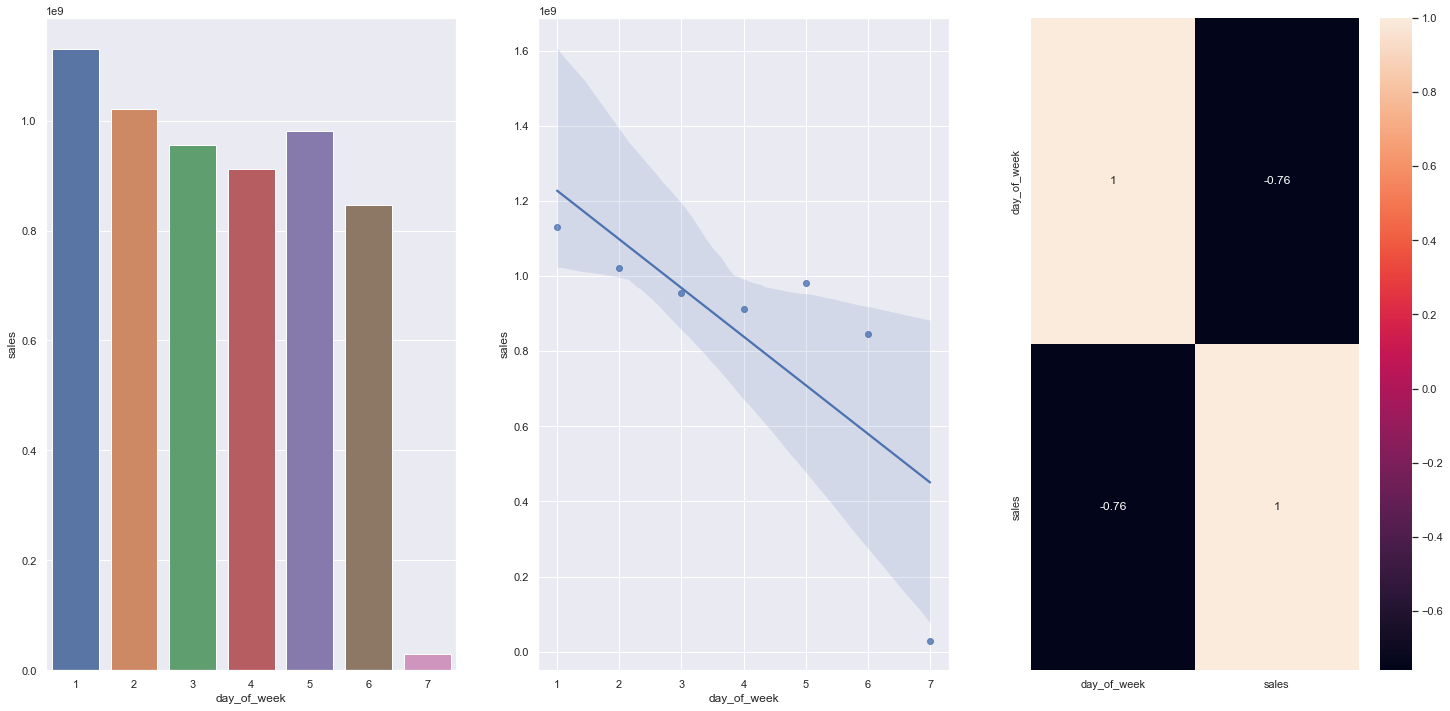

In [51]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### **H12.** Lojas deveriam vender menos durante feriados escolares.
***True*** -  Lojas vendem MENOS nos feriados escolares EXCETO nos meses de julho e agosto.


<AxesSubplot:xlabel='month', ylabel='sales'>

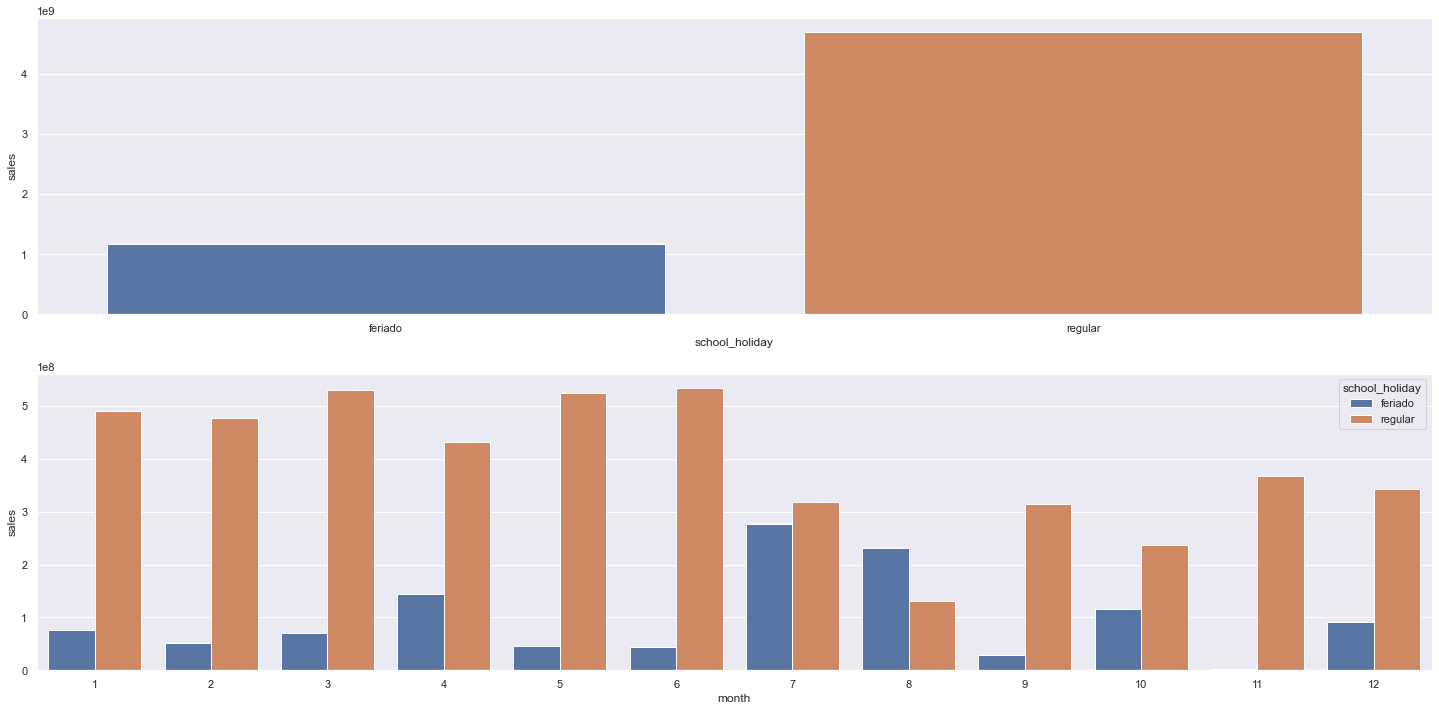

In [52]:
df4['school_holiday'] = df4['school_holiday'].map({0: 'regular', 1: 'feriado'})

plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday',
            'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday',
            'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

### 4.2.1 Resumo das Hipoteses

In [53]:
from tabulate import tabulate

In [54]:
tab = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'False', 'baixa'],
    ['H2', 'False', 'media'],
    ['H3', 'False', 'media'],
    ['H4', 'False', 'baixa'],
    ['H5', '-', '-'],
    ['H6', 'False', 'baixa'],
    ['H7', 'False', 'media'],
    ['H8', 'False', 'alta'],
    ['H9', 'False', 'alta'],
    ['H10', 'True', 'alta'],
    ['H11', 'True', 'alta'],
    ['H12', 'True', 'baixa'],
]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           False        baixa
H2           False        media
H3           False        media
H4           False        baixa
H5           -            -
H6           False        baixa
H7           False        media
H8           False        alta
H9           False        alta
H10          True         alta
H11          True         alta
H12          True         baixa


## 4.3. Analise Multivariada

### 4.3.1 Numerical Atributtes

<AxesSubplot:>

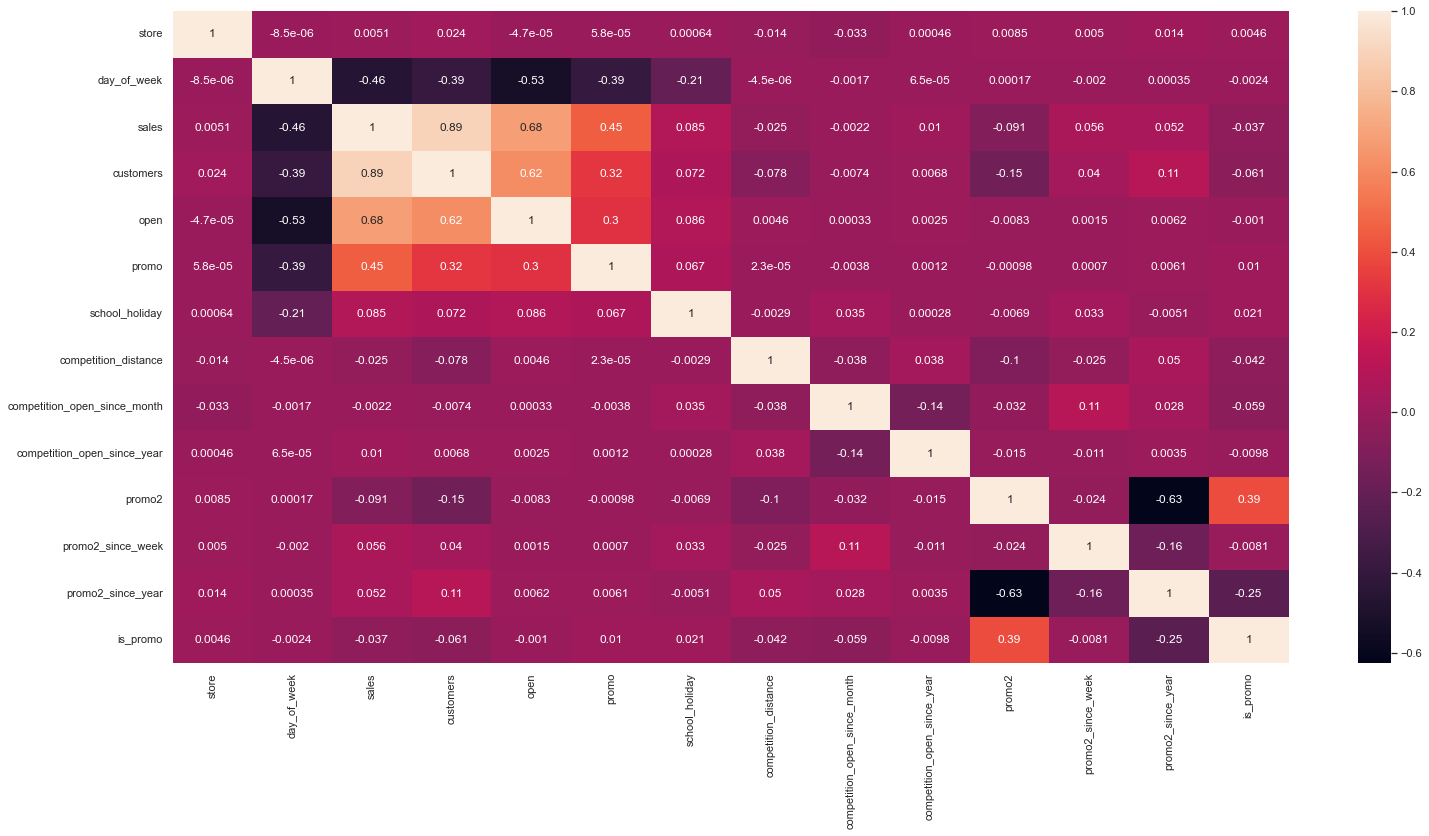

In [55]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.1 Categorical Atributtes

<AxesSubplot:>

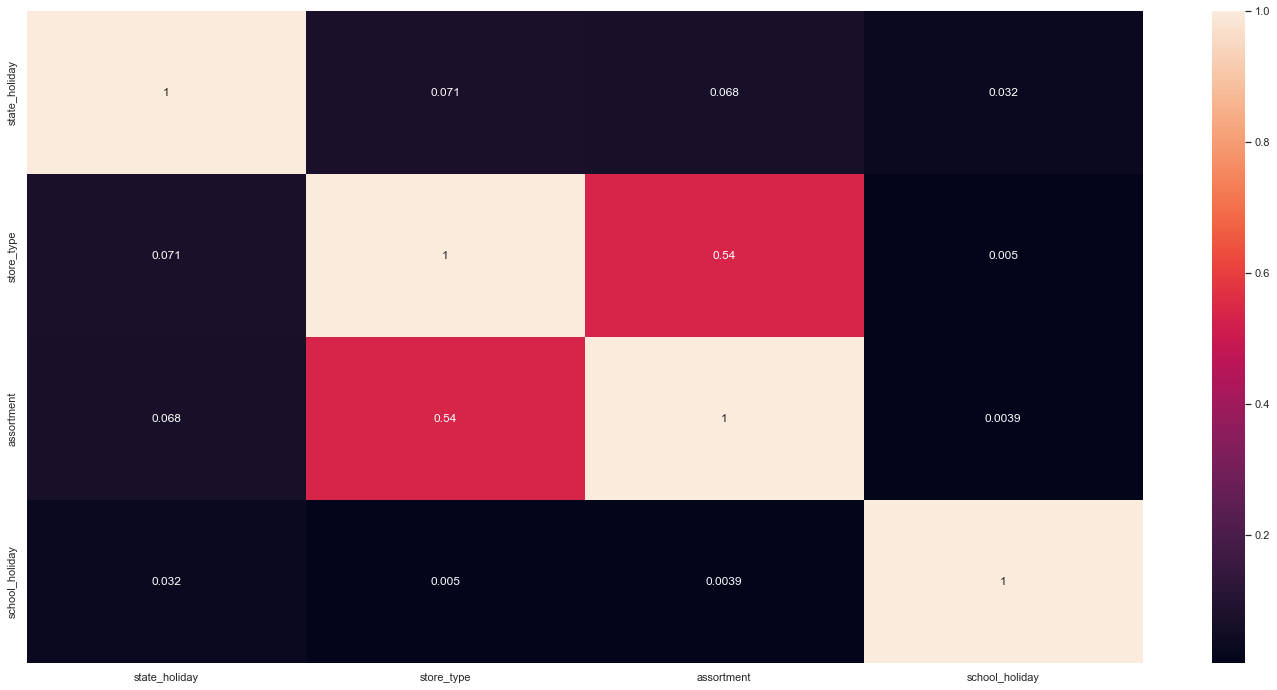

In [56]:
#only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])
a4 = cramer_v(a['state_holiday'], a['school_holiday'])

a5 = cramer_v(a['store_type'], a['state_holiday'])
a6 = cramer_v(a['store_type'], a['store_type'])
a7 = cramer_v(a['store_type'], a['assortment'])
a8 = cramer_v(a['store_type'], a['school_holiday'])

a9 = cramer_v(a['assortment'], a['state_holiday'])
a10 = cramer_v(a['assortment'], a['store_type'])
a11 = cramer_v(a['assortment'], a['assortment'])
a12 = cramer_v(a['assortment'], a['school_holiday'])

a13 = cramer_v(a['school_holiday'], a['state_holiday'])
a14 = cramer_v(a['school_holiday'], a['store_type'])
a15 = cramer_v(a['school_holiday'], a['assortment'])
a16 = cramer_v(a['school_holiday'], a['school_holiday'])

#Final Dataset
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3, a4],
    'store_type': [a5, a6, a7, a8],
    'assortment': [a9, a10, a11, a12],
    'school_holiday': [a13, a14, a15, a16]
})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0. DATA PREPARATION 

In [57]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [58]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_dinstance
df5[['competition_distance']] = rs.fit_transform(df5[['competition_distance'
                                                      ]].values)

# competition time month
df5[['competition_time_month'
     ]] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5[['promo_time_week']] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5[['year']] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformacao

### 5.3.1. Enconding

In [60]:
df5.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
day_of_week,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,10457,8959,8821,6544,9191
promo,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,feriado,feriado,feriado,feriado,feriado,feriado,feriado,feriado,feriado,feriado,feriado,feriado,regular,feriado,feriado
store_type,c,a,a,c,a,a,a,a,a,a,a,a,d,a,d
assortment,basic,basic,basic,extended,basic,basic,extended,basic,extended,basic,extended,extended,basic,basic,extended
competition_distance,-0.17,-0.28,1.90,-0.28,4.45,-0.33,3.50,0.84,-0.05,0.13,-0.22,-0.20,-0.33,-0.17,0.29


In [61]:
# state_holiday -- one_hot_encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# school_holiday -- ordinal encoding
df5['school_holiday'] = df5['school_holiday'].map({'regular': 0, 'feriado': 1})

# store_type -- label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment -- ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [62]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [63]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(
    lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(
    lambda x: np.cos(x * (2. * np.pi / 7)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(
    lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(
    lambda x: np.cos(x * (2. * np.pi / 52)))

# 6.0. FEATURE SELECTION 

In [64]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [65]:
cols_drop = [
    'week_of_year', 'day', 'month', 'day_of_week', 'promo_since',
    'competition_since', 'year_week'
]
df6 = df6.drop(cols_drop, axis=1)

In [66]:
df6[['store', 'date'
     ]].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(
         days=7 * 6)

Timestamp('2015-06-19 00:00:00')

In [67]:
# training dataset

x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset

x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}'.format(x_train['date'].min()))
print('Training Max Date: {}'.format(x_train['date'].max()))
print('\nTest Min Date: {}'.format(x_test['date'].min()))
print('Test Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [69]:
# training and test dataset for boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandoForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy (rf , n_estimators = 'auto' , verbose = 2 ,random_state = 42).fit(x_train_n , y_train_n)

### 6.2.1 Best Features from Boruta

In [70]:
# cols_selected = boruta.support_.tolist()

# # best features
# x_train_fs = x_train.drop(['date','sales'] , axis = 1)
# cols_selected_boruta = x_train_fs.iloc[: , cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns , cols_selected_boruta))

## 6.3. Manual Feature Selection

In [115]:
cols_selected_boruta = [
    'store', 'promo', 'store_type', 'assortment', 'competition_distance',
    'competition_open_since_month', 'competition_open_since_year', 'promo2',
    'promo2_since_week', 'promo2_since_year', 'competition_time_month',
    'promo_time_week', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'day_of_week_sin', 'day_of_week_cos', 'week_of_year_cos',
    'week_of_year_sin'
]

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [119]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# 7.0. MACHINE LEARNING MODELLING

In [73]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

# Time series Data Preparation
x_training = x_train[cols_selected_boruta_full]

## 7.1. Avarage Model

In [82]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Avarage Model', np.expm1(y_test),
                           np.expm1(yhat_baseline))

In [83]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.80,0.21,1835.14


## 7.2. Linear Regression Model

In [86]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# perfomance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

In [87]:
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.09,0.29,2671.05


### 7.2.1.  Linear Regression Model - Cross Validation

In [181]:
model = LinearRegression()
lr_cv = cross_validation('Linear Regression',x_training , 5 , model)
lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso


In [91]:
# model
lasso = Lasso(alpha = 0.01).fit(X_train, y_train)

# prediction
yhat_lasso = lasso.predict(X_test)

# perfomance
lr_result_lasso = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lasso))

In [92]:
lr_result_lasso

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1867.31,0.29,2671.82


### 7.3.1.   Lasso - Cross Validation


In [182]:
model = Lasso(alpha=0.01)
lasso_cv = cross_validation('Lasso',x_training , 5 , model)
lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor Model

In [94]:
# model
RFR = RandomForestRegressor(n_estimators=100 , n_jobs= -1, random_state=42).fit(X_train, y_train)

# prediction
yhat_RFR = RFR.predict(X_test)

# perfomance
lr_result_RFR = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_RFR))

In [95]:
lr_result_RFR

,Model Name,MAE,MAPE,RMSE
0,Random Forest,677.68,0.10,1008.33


### 7.4.1. Random Forest Regressor Model - Cross Validation

In [186]:
model = RandomForestRegressor(n_estimators=100 , n_jobs= -1, random_state=42)
random_cv = cross_validation('Random Forest',x_training , 5 , model)
random_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.82 +/- 218.22,0.12 +/- 0.02,1256.67 +/- 318.4


## 7.5. XGBoost Regressor Model

In [123]:
# model
xb = xgb.XGBRegressor(objective='reg:squarederror',
                      n_estimators=100 ,
                      eta = 0.01 ,
                      max_depth = 10 ,
                      subsample = 0.7,
                      colsample_bytree = 0.9).fit(X_train, y_train)

# prediction
yhat_xb = xb.predict(X_test)

# perfomance
lr_result_xb = ml_error('XGboost Regressor', np.expm1(y_test), np.expm1(yhat_xb))

In [124]:
lr_result_xb

,Model Name,MAE,MAPE,RMSE
0,XGboost Regressor,6683.25,0.95,7330.19


### 7.5.1. XGBoost Regressor Model - Cross Validation

In [187]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                      n_estimators=100 ,
                      eta = 0.01 ,
                      max_depth = 10 ,
                      subsample = 0.7,
                      colsample_bytree = 0.9)

xgb_cv = cross_validation('XGboost Regressor',x_training , 5 , model)
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGboost Regressor,7049.21 +/- 588.56,0.95 +/- 0.0,7715.24 +/- 689.41


## 7.6. Compare Model's Perfomance 

### 7.6.1.  Single Perfomance  - Cross Validation

In [107]:
moddeling_result = pd.concat([baseline_result , lr_result , lr_result_lasso , lr_result_RFR, lr_result_xb  ])
moddeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,677.68,0.10,1008.33
0,Avarage Model,1354.80,0.21,1835.14
0,Linear Regression,1867.09,0.29,2671.05
0,Linear Regression - Lasso,1867.31,0.29,2671.82
0,XGboost Regressor,6683.49,0.95,7330.84


### 7.6.2. Real Perfomance  - Cross Validation

In [189]:
moddeling_result_cv = pd.concat([lr_cv , lasso_cv , random_cv , xgb_cv ])
moddeling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest,837.82 +/- 218.22,0.12 +/- 0.02,1256.67 +/- 318.4
0,XGboost Regressor,7049.21 +/- 588.56,0.95 +/- 0.0,7715.24 +/- 689.41
